# Imports

In [243]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [244]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model      # Model(Inputs = [inputImage , verificationImage] , outputs = [1,0])
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten     # Class LaDist(Layer)
import tensorflow as tf

# Setups

In [245]:
# List gpus installed
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
len(gpus)

[]


0

In [246]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# Limit how much vram tensorflow can use on the gpu

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Folder Structures

In [247]:
# Cuando realizamos la identificación facial, pasaremos dos imágenes, una llamada anchor, que es la que queremos tratar, la imagen que estamos capturando en tiempo real
# También pasaremos una imagen de verificación, una imagen positiva o negativa, con lo que le estaremos diciendo, nuestro anchor match la imagen potitiva
# y no match la negativa

In [248]:
dir_actual= os.getcwd()
ruta_directorio = os.path.join(dir_actual, 'data')
# Verificar si el directorio ya existe
if not os.path.exists(ruta_directorio):
    # Si no existe, crear el directorio
    os.mkdir(ruta_directorio)
    print(f"Directorio 'data' creado en '{dir_actual}'")
else:
    print(f"El directorio 'data' ya existe en '{dir_actual}'")

El directorio 'data' ya existe en 'c:\Users\Usuario\OneDrive\Workplace\Projects_2310\Facial Verification with a Siamese Network'


In [249]:
# Setup paths
POS_PATH = os.path.join(ruta_directorio, 'positive')
NEG_PATH = os.path.join(ruta_directorio, 'negative')
ANC_PATH = os.path.join(ruta_directorio, 'anchor')

In [250]:
# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives and Anchors

## Wild Dataset

In [251]:
# http://vis-www.cs.umass.edu/lfw/

In [252]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [253]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## Collect Positive and Anchor Classes

In [254]:
# Import uuid library to generate unique image names
import uuid

In [255]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'c:\\Users\\Usuario\\OneDrive\\Workplace\\Projects_2310\\Facial Verification with a Siamese Network\\data\\anchor\\8cf64d13-66a7-11ee-90fd-f889d28655b2.jpg'

In [256]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

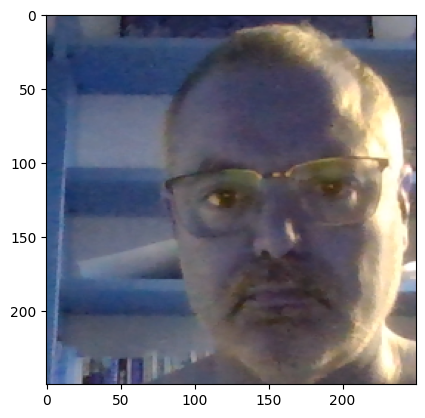

In [257]:
plt.imshow(frame[0:120+250,0:200+250, :])

# Data Augmentation

In [258]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [259]:
img_path = os.path.join(ANC_PATH, '0381a0aa-668a-11ee-8fab-f889d28655b2.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [260]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

In [261]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [262]:
dir_test = anchor.as_numpy_iterator()

In [263]:
print(dir_test.next())

b'c:\\Users\\Usuario\\OneDrive\\Workplace\\Projects_2310\\Facial Verification with a Siamese Network\\data\\anchor\\6fb80cb2-668a-11ee-a0fd-f889d28655b2.jpg'


## Preprocessing - Scale and Resize

In [264]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [265]:
img = preprocess('data\\anchor\\6fb6a9c7-668a-11ee-bd13-f889d28655b2.jpg')

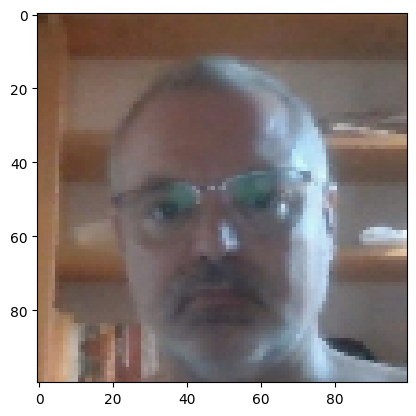

In [266]:
plt.imshow(img)

In [267]:
img.numpy().max()

0.9911765

## Create Labelled Dataset

In [268]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [269]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [270]:
samples = data.as_numpy_iterator()

In [271]:
exampple = samples.next()

In [272]:
exampple

(b'c:\\Users\\Usuario\\OneDrive\\Workplace\\Projects_2310\\Facial Verification with a Siamese Network\\data\\anchor\\6fb8d201-668a-11ee-9a37-f889d28655b2.jpg',
 b'c:\\Users\\Usuario\\OneDrive\\Workplace\\Projects_2310\\Facial Verification with a Siamese Network\\data\\positive\\a1fa938d-66a7-11ee-8791-f889d28655b2.jpg',
 1.0)

## Build Train and Test Partition

In [273]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [274]:
res = preprocess_twin(*exampple)

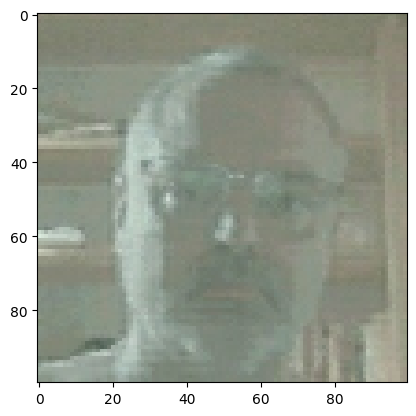

In [275]:
plt.imshow(res[1])

In [276]:
res[2]

1.0

In [277]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [278]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [279]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model 

## Embedding Layer

In [280]:
inp = Input(shape=(100,100,3), name='input_image')

In [281]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [282]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [283]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [284]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [285]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [286]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [287]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [288]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [289]:
embedding = make_embedding()

In [290]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

## Distance Layer

In [291]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [292]:
l1 = L1Dist()

## Siamese Model

In [294]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [295]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [296]:
siamese_layer = L1Dist()

In [297]:
distances = siamese_layer(inp_embedding, val_embedding)

In [298]:
classifier = Dense(1, activation='sigmoid')(distances)

In [299]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [300]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [301]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [302]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [303]:
siamese_model = make_siamese_model()

In [304]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [305]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [306]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [307]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [308]:
test_batch = train_data.as_numpy_iterator()

In [309]:
batch_1 = test_batch.next()

In [310]:
X = batch_1[:2]

In [311]:
y = batch_1[2]

In [312]:
y

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [314]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [315]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [316]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the model

In [317]:
EPOCHS = 50

In [318]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2/2 [==============================] - 64s 28s/step
0.68366075 0.071428575 1.0

 Epoch 2/50
2/2 [==============================] - 59s 24s/step
0.5807873 0.0 0.0

 Epoch 3/50
2/2 [==============================] - 56s 24s/step
0.37302884 0.0 0.0

 Epoch 4/50
2/2 [==============================] - 58s 22s/step
0.6054254 0.0 0.0

 Epoch 5/50
2/2 [==============================] - 50s 21s/step
0.38708705 0.71428573 1.0

 Epoch 6/50
2/2 [==============================] - 53s 22s/step
0.3556566 1.0 1.0

 Epoch 7/50
2/2 [==============================] - 51s 21s/step
0.26986277 1.0 1.0

 Epoch 8/50
2/2 [==============================] - 48s 18s/step
0.17522393 1.0 1.0

 Epoch 9/50
2/2 [==============================] - 45s 18s/step
0.1657814 1.0 1.0

 Epoch 10/50
2/2 [==============================] - 45s 19s/step
0.15594472 1.0 1.0

 Epoch 11/50
2/2 [==============================] - 42s 17s/step
0.17577593 1.0 1.0

 Epoch 12/50
2/2 [==============================] - 41s 17s/step
0.10763933

# Evaluate Model

## Import Metrics

In [319]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## Predictions

In [320]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [321]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


In [322]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]

In [323]:
y_true

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.], dtype=float32)

##Calculate Metrics

In [324]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [325]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [326]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 3s 3s/step
1.0 1.0


## Results visualization

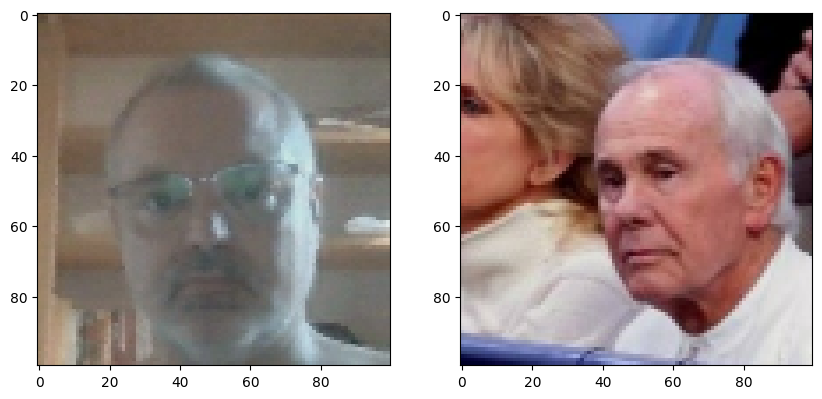

In [327]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Save Model

In [328]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [329]:
L1Dist

__main__.L1Dist

In [330]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [331]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


array([[3.4388126e-08],
       [4.1633569e-10],
       [9.9999982e-01],
       [2.4383613e-09],
       [1.1924850e-10],
       [9.9999535e-01],
       [2.0628910e-10],
       [9.9751657e-01],
       [5.7630340e-09],
       [9.8797828e-01],
       [9.9985790e-01]], dtype=float32)

In [332]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time Test

In [336]:
os.listdir(os.path.join('application_data', 'verification_images'))

['07aa937b-668a-11ee-98f8-f889d28655b2.jpg',
 '7430ef7c-668a-11ee-bd38-f889d28655b2.jpg',
 '7432dc46-668a-11ee-86bc-f889d28655b2.jpg',
 '74333fbd-668a-11ee-8e3c-f889d28655b2.jpg',
 '7433a5d4-668a-11ee-8c16-f889d28655b2.jpg',
 '7433a5d5-668a-11ee-840a-f889d28655b2.jpg',
 '74342ec9-668a-11ee-9085-f889d28655b2.jpg',
 '743442cc-668a-11ee-bafb-f889d28655b2.jpg',
 '7434b54e-668a-11ee-88ee-f889d28655b2.jpg',
 '743503ba-668a-11ee-851a-f889d28655b2.jpg',
 'a11ad09f-66a7-11ee-b313-f889d28655b2.jpg',
 'a13cfaeb-66a7-11ee-90e2-f889d28655b2.jpg',
 'a13da2cf-66a7-11ee-9b6d-f889d28655b2.jpg',
 'a13e427d-66a7-11ee-8ad0-f889d28655b2.jpg',
 'a13f1e67-66a7-11ee-9556-f889d28655b2.jpg',
 'a13fbc87-66a7-11ee-8d4e-f889d28655b2.jpg',
 'a1760c70-66a7-11ee-be68-f889d28655b2.jpg',
 'a18b3dd1-66a7-11ee-b9b1-f889d28655b2.jpg',
 'a18bc792-66a7-11ee-86c0-f889d28655b2.jpg',
 'a18c1758-66a7-11ee-97ee-f889d28655b2.jpg',
 'a1a8c94d-66a7-11ee-849d-f889d28655b2.jpg',
 'a1a97ced-66a7-11ee-929b-f889d28655b2.jpg',
 'a1aa3180

In [337]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [338]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\07aa937b-668a-11ee-98f8-f889d28655b2.jpg
application_data\verification_images\7430ef7c-668a-11ee-bd38-f889d28655b2.jpg
application_data\verification_images\7432dc46-668a-11ee-86bc-f889d28655b2.jpg
application_data\verification_images\74333fbd-668a-11ee-8e3c-f889d28655b2.jpg
application_data\verification_images\7433a5d4-668a-11ee-8c16-f889d28655b2.jpg
application_data\verification_images\7433a5d5-668a-11ee-840a-f889d28655b2.jpg
application_data\verification_images\74342ec9-668a-11ee-9085-f889d28655b2.jpg
application_data\verification_images\743442cc-668a-11ee-bafb-f889d28655b2.jpg
application_data\verification_images\7434b54e-668a-11ee-88ee-f889d28655b2.jpg
application_data\verification_images\743503ba-668a-11ee-851a-f889d28655b2.jpg
application_data\verification_images\a11ad09f-66a7-11ee-b313-f889d28655b2.jpg
application_data\verification_images\a13cfaeb-66a7-11ee-90e2-f889d28655b2.jpg
application_data\verification_images\a13da2cf-66a7-11ee-9b6d-f88

In [339]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

## OpenCV Real Time Verification

In [345]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 182ms/step
False


In [346]:
np.sum(np.squeeze(results) > 0.9)

1

In [347]:
results

[array([[8.6455174e-07]], dtype=float32),
 array([[9.838302e-08]], dtype=float32),
 array([[7.274747e-08]], dtype=float32),
 array([[2.765268e-07]], dtype=float32),
 array([[1.9000149e-06]], dtype=float32),
 array([[1.2444243e-05]], dtype=float32),
 array([[1.0060452e-05]], dtype=float32),
 array([[6.326895e-05]], dtype=float32),
 array([[0.00346468]], dtype=float32),
 array([[0.03775587]], dtype=float32),
 array([[0.11029258]], dtype=float32),
 array([[7.1711064e-08]], dtype=float32),
 array([[7.4306755e-08]], dtype=float32),
 array([[1.2882376e-07]], dtype=float32),
 array([[8.8356046e-07]], dtype=float32),
 array([[3.4352086e-06]], dtype=float32),
 array([[0.26399347]], dtype=float32),
 array([[3.0809265e-06]], dtype=float32),
 array([[1.7599972e-05]], dtype=float32),
 array([[0.00011763]], dtype=float32),
 array([[3.55669e-06]], dtype=float32),
 array([[0.00049392]], dtype=float32),
 array([[0.00716543]], dtype=float32),
 array([[0.06529644]], dtype=float32),
 array([[0.05090306]],